In [1]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {DEVICE}")

using PyTorch version: 2.2.2+cu118, Device: cuda


In [3]:
import os
root_dir = r"E:\DeepLearning\Datasets\man_vs_woman"
print(os.listdir(root_dir)  )

['test', 'train']


In [4]:
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

In [5]:
# 데이터 전처리 및 변환
train_config = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),])        # 이미지를 텐서로 변환
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #정규화 과정

test_config = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),])
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [6]:
train_dataset = datasets.ImageFolder(train_dir, train_config)
test_dataset = datasets.ImageFolder(test_dir, test_config)

In [7]:
train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size= 32, shuffle=False)

In [8]:
images , labels = next(iter(train_dataset_loader))

print(images.shape, type(images), labels.shape, type(labels))

torch.Size([32, 3, 224, 224]) <class 'torch.Tensor'> torch.Size([32]) <class 'torch.Tensor'>


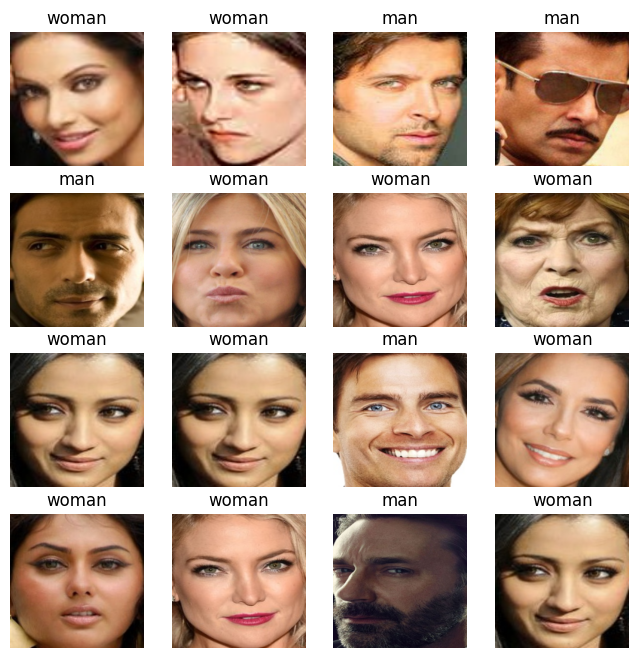

In [9]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당

labels_map = { v:k  for k, v in train_dataset.class_to_idx.items() }

figure = plt.figure(figsize=(8, 8))

cols, rows = 4, 4

# 이미지 출력

for i in range(1,  cols*rows+1):

    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()

    figure.add_subplot(rows, cols, i)

    plt.title(labels_map[label])
    plt.axis("off")

    # 본래 이미지의 shape은 (3, 224, 224) 인데,
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (224, 224, 3)으로 shape 변경을 한 후 시각화
    plt.imshow(torch.permute(img, (1, 2, 0)))

plt.show()

In [10]:

# (3, 224, 224) 배열을 (224, 224, 3) 배열로 바꾸고
images = images.permute(0, 2, 3, 1)

# torch tensor 를 numpy() 로 바꾸고
images = images.numpy()
labels = labels.numpy()

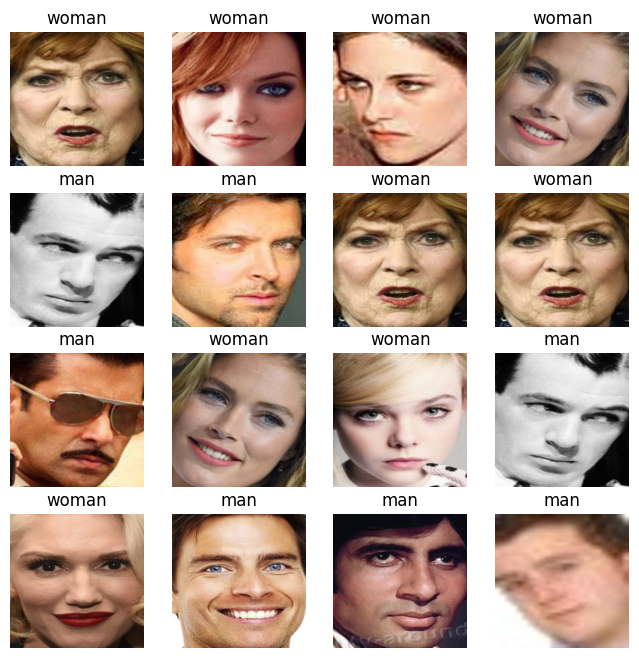

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random

label_map = {
    0 : 'man',
    1 : 'woman'
}

random_idx = np.random.randint(0, len(images), size=16)
plt.figure(figsize=(8, 8))
for i, idx in enumerate(random_idx):
    img = images[idx]
    label_idx = labels[idx]
    label = label_map[label_idx]
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [12]:
from torchvision import transforms, models

pretrained_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
class MyTransferLearningModel(torch.nn.Module):

    def __init__(self, pretrained_model, feature_extractor):

        super().__init__()

        if (feature_extractor):
            for param in pretrained_model.parameters():
                param.require_grad = False

        # vision transformer 에서의 classifier 부분은 heads 로 지정
        pretrained_model.fc = torch.nn.Sequential(
            torch.nn.Linear(pretrained_model.fc.in_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 2)
        )

        self.model = pretrained_model

    def forward(self, data):

        logits = self.model(data)

        return logits

In [16]:
feature_extractor = False  # True: Feature Extractor,  False: Fine Tuning

model = MyTransferLearningModel(pretrained_model, feature_extractor).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6)

In [17]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)

In [18]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [20]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()
EPOCHS = 50

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(test_dataset_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

epoch: 01 train loss = 0.695 train acc = 49.414 val loss = 0.692 val acc = 51.734
epoch: 02 train loss = 0.693 train acc = 50.140 val loss = 0.691 val acc = 55.202
epoch: 03 train loss = 0.689 train acc = 55.053 val loss = 0.689 val acc = 59.249
epoch: 04 train loss = 0.688 train acc = 57.007 val loss = 0.687 val acc = 62.428
epoch: 05 train loss = 0.684 train acc = 60.525 val loss = 0.685 val acc = 63.584
epoch: 06 train loss = 0.683 train acc = 62.535 val loss = 0.683 val acc = 66.763
epoch: 07 train loss = 0.680 train acc = 65.885 val loss = 0.681 val acc = 68.208
epoch: 08 train loss = 0.676 train acc = 68.174 val loss = 0.677 val acc = 70.231
epoch: 09 train loss = 0.675 train acc = 69.458 val loss = 0.675 val acc = 71.676
epoch: 10 train loss = 0.672 train acc = 70.463 val loss = 0.671 val acc = 75.723
epoch: 11 train loss = 0.668 train acc = 72.250 val loss = 0.669 val acc = 76.301
epoch: 12 train loss = 0.664 train acc = 74.372 val loss = 0.664 val acc = 78.902
epoch: 13 train 

In [21]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = 0
        test_correct=0
        test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [22]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_dataset_loader, model)

accuracy: 93.0635838150289
loss: 0.23411480337381363


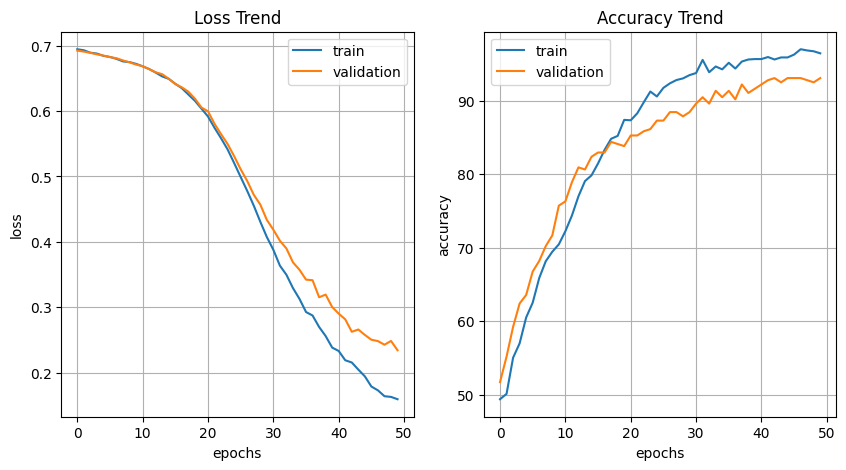

In [23]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()